## Introduction

Author: Saif Rahman

Objective: In this project we'll be using inpatient data from New York Hospitals to make a predictive model on length of stay (LOS)

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import r2_score
from sklearn.tree import export_graphviz
import shap
import graphviz
import matplotlib.pyplot as plt
import re

## Load Data

In [3]:
data = pd.read_csv("Hospital_Inpatient_Discharges__SPARCS_De-Identified___2015.csv")

Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.


In [643]:
data.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5333.90,4818.42
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,NaN,NaN,0,N,Y,4865.99,4588.78
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5901.54,5559.56
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,Minor,Medical,Medicare,NaN,NaN,0,N,Y,3619.08,3567.25
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,Moderate,Medical,Medicare,Blue Cross/Blue Shield,Private Health Insurance,0,N,Y,3185.87,3167.89


In [644]:
data.shape

(2346931, 34)

## Data Cleaning

First we'll remove rows with `NaN` in any categorical columns.

In [645]:
data.isnull().any()

Health Service Area                     True
Hospital County                         True
Operating Certificate Number            True
Facility Id                             True
Facility Name                          False
Age Group                              False
Zip Code - 3 digits                     True
Gender                                 False
Race                                   False
Ethnicity                              False
Length of Stay                         False
Type of Admission                      False
Patient Disposition                    False
Discharge Year                         False
CCS Diagnosis Code                     False
CCS Diagnosis Description              False
CCS Procedure Code                     False
CCS Procedure Description              False
APR DRG Code                           False
APR DRG Description                    False
APR MDC Code                           False
APR MDC Description                    False
APR Severi

In [4]:
data = data[data['Health Service Area'].notna()]

In [5]:
data = data[data['Zip Code - 3 digits'].notna()]

For `APR Severity of Illness Description`, this column has a corresponding label encoded column `APR Severity of Illness Code`, so we'll drop it entirely.

In [6]:
data.drop(columns='APR Severity of Illness Description', inplace=True)

For `APR Risk of Mortality`, this has no corresponding label encoded column, so we'll replace it with our own version.

In [649]:
data['APR Risk of Mortality'].value_counts()

Minor       1366995
Moderate     493661
Major        330708
Extreme      119642
Name: APR Risk of Mortality, dtype: int64

In [7]:
data['APR Risk of Mortality'] = data['APR Risk of Mortality'].map({np.nan:0,'Minor':1,'Moderate':2,'Major':3,'Extreme':4})

For the `Payment Typology #`, we won't drop the nulls, as this information may be helpful to know, so we'll treat it as another category. We'll fix this in our feature engineering step.

Another issue is the column `Length of Stay`, which contains the number of days the patient stayed at the hospital. This is currently a string, as one value is `120 +`. So we'll convert this into a value of 120, and the rest will be their integer values.

In [651]:
data['Length of Stay'].value_counts()

2      508026
3      397775
1      315122
4      232118
5      150334
        ...  
103         1
79          1
78          1
76          1
88          1
Name: Length of Stay, Length: 221, dtype: int64

In [8]:
data['Length of Stay'] = data['Length of Stay'].apply(lambda x: 120 if x== '120 +' else int(x))

In [9]:
data.shape

(2311115, 33)

In [10]:
def clean_disp(disp):
    '''
    Filters down patient disposition categories
    '''
    if disp in ['Home or Self Care','Home w/ Home Health Services','Hospice - Home']:
        return 'Home'
    if 'Facility' in disp:
        return 'Facility'
    if 'Hospital' in disp:
        return 'Hospital'
    else:
        return 'Other'

In [11]:
data['Patient Disposition'] = data['Patient Disposition'].apply(clean_disp)

## Data Exploration

Tableau Link: https://public.tableau.com/profile/saif.rahman#!/vizhome/inpatient_visualizations/HospitalDataExploration?publish=yes

## Feature Selection

We'll remove any columns with zero variance, in other words any constant columns

In [656]:
describe = data.describe().T
describe[describe['std'] == 0]

,count,mean,std,min,25%,50%,75%,max
Discharge Year,2311115.0,2015.0,0.0,2015.0,2015.0,2015.0,2015.0,2015.0


In [12]:
data.drop(columns='Discharge Year', inplace=True)

In [658]:
data.shape

(2311115, 32)

We'll drop any numeric columns that refer to IDs and columns with corresponding descriptions. This is redundant information.

In [394]:
data.head()

,Health Service Area,Hospital County,Operating Certificate Number,Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Abortion Edit Indicator,Emergency Department Indicator,Total Charges,Total Costs
0,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,1,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5333.90,4818.42
1,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,2,Medical,Medicare,NaN,NaN,0,N,Y,4865.99,4588.78
2,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,F,White,Not Span/Hispanic,...,1,Medical,Medicare,Private Health Insurance,NaN,0,N,Y,5901.54,5559.56
3,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,50 to 69,147,F,White,Not Span/Hispanic,...,1,Medical,Medicare,NaN,NaN,0,N,Y,3619.08,3567.25
4,Western NY,Allegany,226700.0,37.0,Cuba Memorial Hospital Inc,70 or Older,147,M,White,Not Span/Hispanic,...,2,Medical,Medicare,Blue Cross/Blue Shield,Private Health Insurance,0,N,Y,3185.87,3167.89


In [13]:
ids = ['Operating Certificate Number','Facility Id','Zip Code - 3 digits','CCS Diagnosis Code','CCS Procedure Code',
       'APR DRG Code','APR MDC Code']

data.drop(columns=ids, inplace=True)

In [14]:
data.shape

(2311115, 25)

In [661]:
data.corr()

,Length of Stay,APR Severity of Illness Code,APR Risk of Mortality,Birth Weight,Total Charges,Total Costs
Length of Stay,1.000000,0.346454,0.298655,-0.094737,0.705771,0.714261
APR Severity of Illness Code,0.346454,1.000000,0.750184,-0.262982,0.331090,0.316911
APR Risk of Mortality,0.298655,0.750184,1.000000,-0.225630,0.313142,0.297632
Birth Weight,-0.094737,-0.262982,-0.225630,1.000000,-0.113392,-0.118588
Total Charges,0.705771,0.331090,0.313142,-0.113392,1.000000,0.904258
Total Costs,0.714261,0.316911,0.297632,-0.118588,0.904258,1.000000


We'll also drop highly correlated values. 

In [15]:
high_corr = ['APR Risk of Mortality','Total Costs']
data.drop(columns=high_corr, inplace=True)

In [16]:
data.shape

(2311115, 23)

## Feature Engineering

We'll create a column representing the amount of payment typologies the patient has available. We'll also change our `NaN`s in the payment typologies to categories of their own.

In [17]:
data['num_typologies'] = data[['Payment Typology 1','Payment Typology 2','Payment Typology 3']].notnull().sum(axis=1)

In [18]:
data['num_typologies'].value_counts()

2    918736
1    725011
3    667368
Name: num_typologies, dtype: int64

In [19]:
data['Payment Typology 2'].fillna('No Payment',inplace=True)
data['Payment Typology 3'].fillna('No Payment',inplace=True)

We'll create a column label encoding the `Age Group` column

In [20]:
data['Age Group'].value_counts()

70 or Older    639048
50 to 69       636176
30 to 49       448208
0 to 17        347321
18 to 29       240362
Name: Age Group, dtype: int64

In [21]:
data['Age Encoded'] = data['Age Group'].map({'0 to 17': 0, '18 to 29': 1, '30 to 49': 2, '50 to 69':3,'70 or Older':4})

In [22]:
data.drop(columns='Age Group', inplace=True)

In [23]:
data.corr()

,Length of Stay,APR Severity of Illness Code,Birth Weight,Total Charges,num_typologies,Age Encoded
Length of Stay,1.000000,0.346454,-0.094737,0.705771,0.057925,0.112810
APR Severity of Illness Code,0.346454,1.000000,-0.262982,0.331090,0.147034,0.392122
Birth Weight,-0.094737,-0.262982,1.000000,-0.113392,-0.086892,-0.575820
Total Charges,0.705771,0.331090,-0.113392,1.000000,0.068218,0.134264
num_typologies,0.057925,0.147034,-0.086892,0.068218,1.000000,0.207695
Age Encoded,0.112810,0.392122,-0.575820,0.134264,0.207695,1.000000


We'll perform frequency encoding on columns with large category counts

In [24]:
data['Hospital County'] = data['Hospital County'].map(data.groupby(['Hospital County']).size()/len(data))

In [25]:
data['Facility Name'] = data['Facility Name'].map(data.groupby(['Facility Name']).size()/len(data))

In [26]:
data['CCS Diagnosis Description'] = data['CCS Diagnosis Description'].map(data.groupby(['CCS Diagnosis Description']).size()/len(data))

In [27]:
data['CCS Procedure Description'] = data['CCS Procedure Description'].map(data.groupby(['CCS Procedure Description']).size()/len(data))

In [28]:
data['APR DRG Description'] = data['APR DRG Description'].map(data.groupby(['APR DRG Description']).size()/len(data))

## Modelling

In [29]:
def col_renamer(cols):
    '''
    This function reduces the name of the longest column names for easier interpretation.
    '''
    col_dict = {}
    for i in range(len(cols)):
        col_dict[cols[i]] = cols[i].replace('APR MDC Description_','').replace('APR Medical Surgical Description_','').strip()
    return col_dict

We'll drop `Length of Stay` as this is our label column, `Total Charges` as we typically wouldn't have this information on live data, and the `Payment Typologies`, as after further testing this was seen to hurt the model and not use many features. The scores with and without them did not change.

In [30]:
drop_features = ['Payment Typology 1','Payment Typology 2','Payment Typology 3','Total Charges','Length of Stay']

In [31]:
X = pd.get_dummies(data.drop(columns=drop_features),drop_first=True)
X = X.rename(columns=col_renamer(X.columns)) # apply column renamer
y = data['Length of Stay']

In [825]:
X.shape

(2311115, 59)

In [32]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

For each model, we'll set up a pipeline to scale our data.

### Linear Regression

In [1122]:
lr = Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])

In [1123]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, val_index in kf.split(X_train_full):
    X_train, X_val = X_train_full.iloc[train_index], X_train_full.iloc[val_index]
    y_train, y_val = y_train_full.iloc[train_index], y_train_full.iloc[val_index]
    
    lr.fit(X_train,y_train)
    
    y_pred = lr.predict(X_val)
    
    print(f'RMSE: {mean_squared_error(y_val, y_pred,squared=False)}')
    print(f'R2: {r2_score(y_val, y_pred)}')
    print('-----------------------------------')

RMSE: 6.951600972900559
R2: 0.2313067184336406
-----------------------------------
RMSE: 7.1288293816880985
R2: 0.22846238120151874
-----------------------------------
RMSE: 7.0615970386523905
R2: 0.2287189246285951
-----------------------------------
RMSE: 6.99042875954541
R2: 0.233431316759809
-----------------------------------
RMSE: 6.962627459266868
R2: 0.23177703000513006
-----------------------------------


In [1124]:
y_pred = lr.predict(X_test)

print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'R2: {r2_score(y_test, y_pred)}')

RMSE: 6.961935858931291
R2: 0.23080956048082568


The RMSE scores are decent, however the R2 score displays a weak fit to the data. 

Now, let's look at the feature importances.

In [840]:
first = pd.Series(lr['LR'].coef_, index=X.columns).sort_values()[:10]
other = pd.Series(lr['LR'].coef_, index=X.columns).sort_values()[-10:]
key_features = first.append(other)

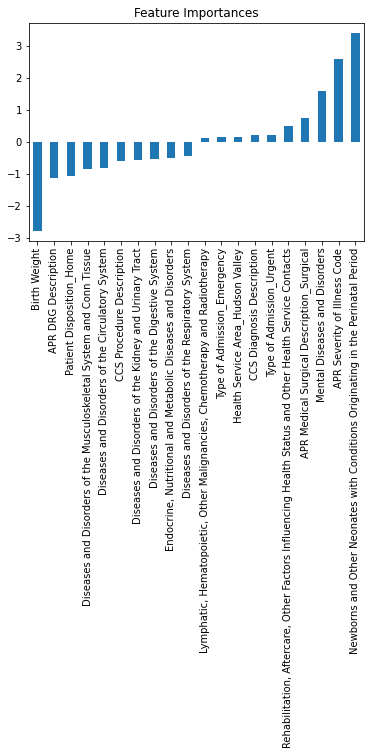

In [841]:
key_features.plot(kind='bar',title = 'Feature Importances',);

### Decision Tree Regressor

Here we'll set up a gridsearch with our pipeline, to achieve a hypertuned model.

In [951]:
dtr = Pipeline([('Scaler', StandardScaler()),('DTR',DecisionTreeRegressor())])

In [952]:
parameters = {
    'DTR__max_depth': [5,10,15],
}

dtr_gcv = GridSearchCV(dtr,param_grid=parameters,scoring=['r2','neg_mean_squared_error','neg_median_absolute_error',
                                                         'neg_root_mean_squared_error'],
                      refit='r2',cv=5,n_jobs=-1,verbose=-10)

In [953]:
dtr_gcv.fit(X_train_full,y_train_full)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('DTR', DecisionTreeRegressor())]),
             n_jobs=-1, param_grid={'DTR__max_depth': [5, 10, 15]}, refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_median_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=-10)

In [954]:
dtr_gcv.best_estimator_

Pipeline(steps=[('Scaler', StandardScaler()),
                ('DTR', DecisionTreeRegressor(max_depth=10))])

Our best model is a decision tree with a max depth 10

In [955]:
dtr_df = pd.DataFrame(dtr_gcv.cv_results_)
best_dtr = dtr_df[dtr_df['rank_test_r2'] == 1]
best_dtr[['params','rank_test_r2','split2_test_r2', 'split3_test_r2', 'split4_test_r2', 'mean_test_r2',
       'std_test_r2']]

,params,rank_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2
1,{'DTR__max_depth': 10},1,0.37656,0.392726,0.382554,0.385569,0.006177


In [1121]:
y_pred = dtr_gcv.best_estimator_.predict(X_test)
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'R2: {r2_score(y_test, y_pred)}')

RMSE: 6.230885795756039
R2: 0.38386848331230716


The model has a similar RMSE to the linear regression model, but the R2 score is much better.

### Decision Tree Regressor Interpretion

After testing all the models (including below ones), the decision tree regressor was seen as the best model, so we will focus on interpreting just this model.

Let's visualize our decision tree.

In [844]:
dot_data = export_graphviz(dtr['DTR'], out_file=None, feature_names=X.columns,  
                                filled=True, special_characters=True)  

graphviz.Source(dot_data)

Now for our feature importances.

In [1175]:
sns_df.columns

Index(['index', 0], dtype='object')

In [1187]:
sns.set_palette("Reds")

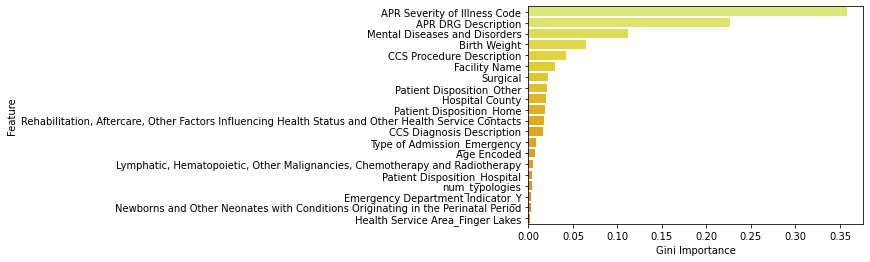

In [1210]:
sns_df = pd.Series(rf_gcv.best_estimator_['DTR'].feature_importances_, index=X.columns).sort_values(ascending=False)[:20].reset_index()
sns_df = sns_df.rename(columns={0: 'Gini Importance', 'index':'Feature'})
ax = sns.barplot(x='Gini Importance',y='Feature',data=sns_df,palette='Wistia')

Let's get a more detailed look at the models predictions

In [1090]:
difference = pd.Series(abs(y_test - y_pred)).drop(columns='index')

In [1209]:
df_interpret['Difference'].std()

5.508120434297089

In [1094]:
df_interpret = pd.DataFrame(difference).rename(columns={'Length of Stay': 'Difference'})
df_interpret['y_pred'] = y_pred
df_interpret['y_test'] = y_test
df_interpret.sort_values(by='Difference').head()

,Difference,y_pred,y_test
298284,119.000000,120.000000,1
917767,117.554446,2.445554,120
463086,117.482087,2.517913,120
1760463,117.226681,2.773319,120
1260723,116.824385,3.175615,120


In [1097]:
full_table = pd.merge(X_test.loc[list(df_interpret.index)],df_interpret, left_index=True, right_index=True)\
.sort_values('Difference',ascending=False).drop(columns=['Difference','y_pred','y_test'])
full_table.head()

,Hospital County,Facility Name,CCS Diagnosis Description,CCS Procedure Description,APR DRG Description,APR Severity of Illness Code,Birth Weight,num_typologies,Age Encoded,Health Service Area_Central NY,...,Mental Diseases and Disorders,Multiple Significant Trauma,Newborns and Other Neonates with Conditions Originating in the Perinatal Period,"Poisonings, Toxic Effects, Other Injuries and Other Complications of Treatment",Pre-MDC or Ungroupable,"Pregnancy, Childbirth and the Puerperium","Rehabilitation, Aftercare, Other Factors Influencing Health Status and Other Health Service Contacts",APR Medical Surgical Description_Not Applicable,APR Medical Surgical Description_Surgical,Emergency Department Indicator_Y
298284,0.000255,0.000255,0.000135,0.002408,0.000419,4,0,2,3,0,...,0,0,0,0,0,0,0,0,0,0
917767,0.079795,0.008171,0.000851,0.074584,0.005451,1,0,1,4,0,...,0,0,0,0,0,0,0,0,0,1
463086,0.033545,0.009640,0.011344,0.015179,0.063046,2,0,1,1,1,...,0,0,0,0,0,1,0,0,0,0
1760463,0.084329,0.009010,0.018315,0.022775,0.014121,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1260723,0.106178,0.017045,0.004019,0.260115,0.006222,2,0,3,4,0,...,0,0,0,0,0,0,0,0,0,1


In [1107]:
X100 = shap.utils.sample(full_table[:1000], 100) # 100 instances for use as the background distribution

explainer = shap.Explainer(rf_gcv.best_estimator_.predict,X100)
shap_values = explainer(full_table[:1000])

Permutation explainer:  31%|███       | 306/1000 [00:29<03:17,  3.51it/s]


Permutation explainer:  21%|██        | 212/1000 [00:00<?, ?it/s]

Permutation explainer:  22%|██▏       | 215/1000 [00:10<00:26, 29.76it/s]

Permutation explainer:  22%|██▏       | 217/1000 [00:10<00:30, 25.91it/s]

Permutation explainer:  22%|██▏       | 219/1000 [00:10<00:33, 23.63it/s]

Permutation explainer:  22%|██▏       | 221/1000 [00:10<00:35, 22.22it/s]

Permutation explainer:  22%|██▏       | 223/1000 [00:10<00:37, 20.93it/s]

Permutation explainer:  22%|██▎       | 225/1000 [00:10<00:39, 19.82it/s]

Permutation explainer:  23%|██▎       | 227/1000 [00:10<00:40, 19.13it/s]

Permutation explainer:  23%|██▎       | 229/1000 [00:10<00:40, 18.93it/s]

Permutation explainer:  23%|██▎       | 231/1000 [00:10<00:39, 19.23it/s]

Permutation explainer:  23%|██▎       | 233/1000 [00:11<00:40, 19.16it/s]

Permutation explainer:  24%|██▎       | 235/1000 [00:11<00:39, 19.37it/s]

Permutation explainer:  24%|██▎ 

Permutation explainer:  63%|██████▎   | 633/1000 [00:32<00:19, 18.77it/s]

Permutation explainer:  64%|██████▎   | 635/1000 [00:32<00:19, 19.06it/s]

Permutation explainer:  64%|██████▎   | 637/1000 [00:32<00:19, 18.88it/s]

Permutation explainer:  64%|██████▍   | 639/1000 [00:32<00:19, 18.86it/s]

Permutation explainer:  64%|██████▍   | 641/1000 [00:32<00:18, 19.01it/s]

Permutation explainer:  64%|██████▍   | 643/1000 [00:32<00:18, 18.93it/s]

Permutation explainer:  64%|██████▍   | 645/1000 [00:32<00:18, 18.90it/s]

Permutation explainer:  65%|██████▍   | 647/1000 [00:33<00:18, 18.77it/s]

Permutation explainer:  65%|██████▍   | 649/1000 [00:33<00:18, 18.87it/s]

Permutation explainer:  65%|██████▌   | 651/1000 [00:33<00:18, 19.00it/s]

Permutation explainer:  65%|██████▌   | 653/1000 [00:33<00:18, 19.02it/s]

Permutation explainer:  66%|██████▌   | 655/1000 [00:33<00:18, 18.79it/s]

Permutation explainer:  66%|██████▌   | 657/1000 [00:33<00:18, 18.85it/s]

Permutation explainer:  6

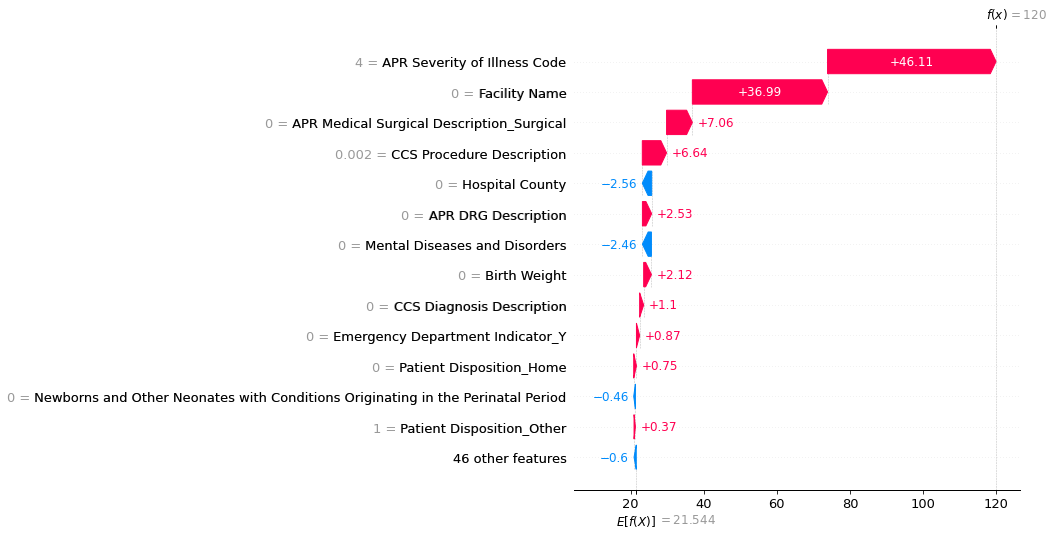

In [1118]:
shap.plots.waterfall(shap_values[0], max_display=14)

We'll look at the first shap value, which was a patient predict to stay at the hospital for 120 days, but actual stayed for 1 day. Using SHAP, it appears the model used the severity of illness code heavily to make its prediction.

### Ridge Regression

In [916]:
ridge = Pipeline([('Scaler', StandardScaler()),('Ridge',Ridge())])
parameters = {
    'Ridge__alpha': [7,10,15] # chosen by arbitrarily testing numbers, not much increase in scores
}

ridge_gcv = GridSearchCV(ridge,param_grid=parameters,scoring=['r2','neg_mean_squared_error','neg_median_absolute_error',
                                                         'neg_root_mean_squared_error'],
                      refit='r2',cv=5,n_jobs=-1,verbose=-10)
ridge_gcv.fit(X_train_full, y_train_full)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('Ridge', Ridge())]),
             n_jobs=-1, param_grid={'Ridge__alpha': [2, 4, 7]}, refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_median_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=-10)

In [948]:
pd.DataFrame(ridge_gcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_Ridge__alpha,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,...,std_test_neg_median_absolute_error,rank_test_neg_median_absolute_error,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,split2_test_neg_root_mean_squared_error,split3_test_neg_root_mean_squared_error,split4_test_neg_root_mean_squared_error,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error
0,54.586871,7.378313,0.901446,0.130901,2,{'Ridge__alpha': 2},0.229052,0.229251,0.229187,0.234167,...,0.003881,3,-7.118132,-7.093482,-7.013206,-6.984545,-6.969966,-7.035866,0.059291,3
1,42.977309,11.353062,1.363116,0.762499,4,{'Ridge__alpha': 4},0.229052,0.229251,0.229187,0.234167,...,0.003864,2,-7.118132,-7.093482,-7.013206,-6.984545,-6.969967,-7.035866,0.059291,2
2,22.262025,1.668584,0.396212,0.067657,7,{'Ridge__alpha': 7},0.229052,0.229251,0.229187,0.234167,...,0.003846,1,-7.118132,-7.093481,-7.013205,-6.984545,-6.969967,-7.035866,0.059291,1


In [949]:
pd.DataFrame(ridge_gcv.cv_results_)[['params','split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'split3_test_r2', 'split4_test_r2']]

,params,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2
0,{'Ridge__alpha': 2},0.229052,0.229251,0.229187,0.234167,0.231321
1,{'Ridge__alpha': 4},0.229052,0.229251,0.229187,0.234167,0.231321
2,{'Ridge__alpha': 7},0.229052,0.229251,0.229187,0.234167,0.231321


In [1120]:
y_pred = ridge_gcv.best_estimator_.predict(X_test)
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'R2: {r2_score(y_test, y_pred)}')

RMSE: 6.962078138869769
R2: 0.23077812052247548


This model has similar scores to our linear regression model so we'll disregard it.

In [946]:
first = pd.Series(ridge_gcv.best_estimator_['Ridge'].coef_, index=X.columns).sort_values()[:12]
other = pd.Series(ridge_gcv.best_estimator_['Ridge'].coef_, index=X.columns).sort_values()[-12:]
key_features = first.append(other)

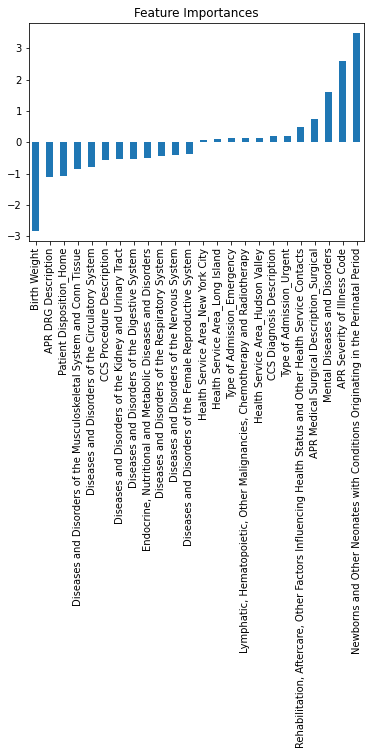

In [947]:
key_features.plot(kind='bar',title = 'Feature Importances',);

### Lasso Regression

In [920]:
clf = Pipeline([('Scaler', StandardScaler()),('CLF',Lasso())])
parameters = {
    'CLF__alpha': [0.01,0.05,0.1]
}

clf_gcv = GridSearchCV(clf,param_grid=parameters,scoring=['r2','neg_mean_squared_error','neg_median_absolute_error',
                                                         'neg_root_mean_squared_error'],
                      refit='r2',cv=5,n_jobs=-1,verbose=-10)

In [921]:
clf_gcv.fit(X_train_full, y_train_full)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', StandardScaler()),
                                       ('CLF', Lasso())]),
             n_jobs=-1, param_grid={'CLF__alpha': [0.01, 0.05, 0.1]},
             refit='r2',
             scoring=['r2', 'neg_mean_squared_error',
                      'neg_median_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=-10)

In [922]:
clf_gcv.best_estimator_

Pipeline(steps=[('Scaler', StandardScaler()), ('CLF', Lasso(alpha=0.01))])

In [926]:
pd.DataFrame(clf_gcv.cv_results_)[['split0_test_r2', 'split1_test_r2',
       'split2_test_r2', 'split3_test_r2', 'split4_test_r2']]

,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2
0,0.228371,0.228777,0.228905,0.233602,0.230802
1,0.222463,0.223740,0.224244,0.227806,0.225048
2,0.213814,0.215557,0.216328,0.219137,0.216715


In [1126]:
y_pred = clf_gcv.best_estimator_.predict(X_test)
print(f'RMSE: {mean_squared_error(y_test, y_pred,squared=False)}')
print(f'R2: {r2_score(y_test, y_pred)}')

RMSE: 6.964577287174967
R2: 0.23022577262980293


This model has similar split r2 scores as our linear regression model so we'll disregard this model.

## Conclusion

We collected inpatient data from New York hospitals, in attempt to create a predictive model on the length of stay for inpatients. Overall, the patient records given didn't give too much detail into their demographics, but were decent in terms of diagnoses. 

The algorithms used were linear regression, decision tree regression, ridge regression, and lasso regression. Each model had similar RMSE scores, so R2 metrics were introduced to measure the fit of the model on the actual data. After a series of tests, the R2 score was the best for the decision tree regression algorithm, achieving a score of 0.384 on the test set. However, the model made key mistakes in interpreting some patients to be in hospitals much longer/shorter than they actual would be. Using SHAP, we were able to see that many of these incorrect patients predicts were due to a large influence in the severity of illness score. 

For future steps, additional information such as exact age, past illnesses, date information, and others, in addition to feature engineering variables and a further division of diagnoses would help achieve better results on the model.

## Acknowledgements


- Data Source: https://health.data.ny.gov/Health/Hospital-Inpatient-Discharges-SPARCS-De-Identified/82xm-y6g8
- SHAP Documentation: https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html#linear_regression
- LOS Example: https://github.com/daniel-codes/hospital-los-predictor/blob/master/hospital_los_prediction.ipynb